# IRAF-like: photutils

[photutils]() provides a couple of options for stellar source detection that will be familiar to users of IRAF. One is DAOFIND and the other is IRAF's starfind. The recommendation is to use DAOFIND because it is more general than starfind (e.g. it allows elliptical sources) and detects more sources. This notebook will focus on DAOFIND, implemented in photutils by the class `DAOStarFinder`.

Both methods find sources above a threshold that is specified as a multiple of the background noise level, and both require that the background be subtracted from the image.

You can use any of the background subtraction methods that you like; often simply subtracting the median will be adequate, which is what we will do in this notebook. 

## DAOPHOT

DAOStarFinder is a class that provides an implementation of the DAOFIND algorithm (Stetson 1987, PASP 99, 191). It searches images for local density maxima that have a peak amplitude greater than a specified threshold (the threshold is applied to a convolved image) and have a size and shape similar to a defined 2D Gaussian kernel. DAOStarFinder also provides an estimate of the objects’ roundness and sharpness, whose lower and upper bounds can be specified.

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from photutils.datasets import load_star_image
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture

from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.stats import sigma_clipped_stats, SigmaClip


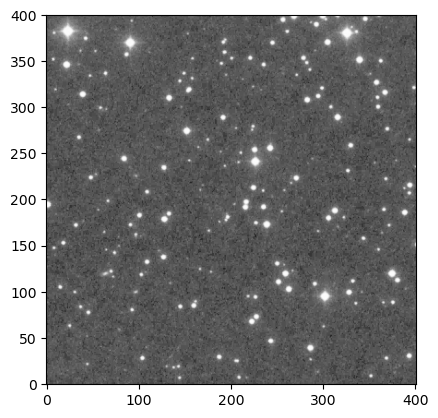

In [2]:
# photutils allows us to easily access one of their example images
hdu = load_star_image()  
# We will only consider a small portion of the image, for faster processing
data = hdu.data[0:401, 0:401]  

# Plot the image with a square-root normalization
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, norm=norm, origin='lower', cmap='Greys_r')

In [13]:
# Use sigma-clipped statistics to estimate the background & background noise
clipped_mean, clipped_med, clipped_std = sigma_clipped_stats(data, sigma=3.0) 
print(clipped_mean, clipped_med, clipped_std)

3668.09661145823 3649.0 204.41388592022315


Now we will subtract the background and use an instance of DAOStarFinder to find the stars in the image that have FWHMs of around 3 pixels and have peaks approximately 5-sigma above the background. Running this class on the data yields an astropy Table containing the results of the star finder.

Note that at this point, the star positions are given in pixel coordinates (x and y). The locations are not restricted by the pixel grid; DAOfind will estimate the centroid position to 1% of a pixel. 

In [10]:
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)  
sources = daofind(data - median)  
for col in sources.colnames:  
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'  # for consistent table output
sources.pprint(max_width=76)  

 id xcentroid ycentroid sharpness roundness1 ... sky    peak  flux  mag 
--- --------- --------- --------- ---------- ... ---- ------- ---- -----
  1    144.25      6.38      0.58       0.20 ... 0.00 6903.00 5.70 -1.89
  2    208.67      6.82      0.48      -0.13 ... 0.00 7896.00 6.72 -2.07
  3    216.93      6.58      0.69      -0.71 ... 0.00 2195.00 1.67 -0.55
  4    351.63      8.55      0.49      -0.34 ... 0.00 6977.00 5.90 -1.93
  5    377.52     12.07      0.52       0.37 ... 0.00 1260.00 1.12 -0.12
  6    294.27     12.74      0.68       0.11 ... 0.00 2059.00 1.48 -0.43
  7     85.22     14.71      0.62      -0.93 ... 0.00 1458.00 1.25 -0.24
...       ...       ...       ...        ... ...  ...     ...  ...   ...
280    351.48    394.68      0.64       0.79 ... 0.00 1545.00 1.06 -0.07
281    345.59    395.38      0.38       0.07 ... 0.00 9350.00 5.05 -1.76
282    267.90    398.62      0.27      -0.43 ... 0.00 9299.00 5.44 -1.84
283    271.47    398.91      0.37       0.19 ... 0.

Let’s plot the image and mark the location of detected sources

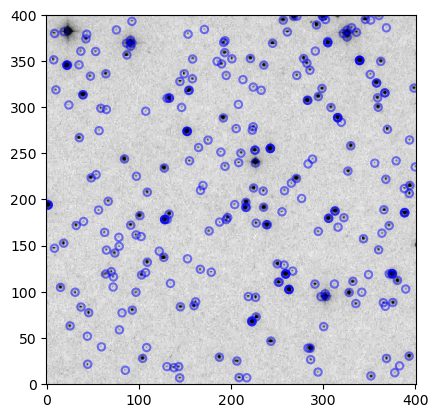

In [12]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.0)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
_ = apertures.plot(color='blue', lw=1.5, alpha=0.5)